In [12]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from gekko import GEKKO

## Summary of the notebook

This Jupyter Notebook document contains the analysis and modeling of two pumps: AWMT and Wilo. The pumps have been modeled using static, ARX, and OE models. The key results include the estimated equations for pump feedback, the coefficients of these equations, and the root mean square (RMS) errors for the ARX and OE models.

For all the models, `y_m` denotes the measured pump feedback, `y_p` denotes the predicted pump feedback, `u` denotes the set pump duty cycle, and the `avg` subscript denotes a rolling average of the signal.

The summary table below provides an overview of the models and their corresponding results:

| Pump | Model | Model | RMS error |
| --- | --- | --- | --- |
| AWMT | Static | y_avg = -0.08 * u_avg + 55.04 | - |
| AWMT | ARX | y_p(k+1) = 0.0293 * u(k) + -0.0717 * u(k-1) + 0.4661 * y_m(k) + -0.0872 * y_m(k-1) + 31.7933 | 10.68 |
| AWMT | OE | y_p(k+1) = 0.0241 * u(k) + -0.0629 * u(k-1) + 0.8170 * y_p(k) + -0.3496 * y_p(k-1) + 28.4732 | 11.28 |
| Wilo | Static | - | - |
| Wilo | ARX | y_p(k+1) = 0.0265 * u(k) + -0.0613 * u(k-1) + 0.6245 * y_m(k) + -0.2667 * y_m(k-1) + 28.6556 | 10.24 |
| Wilo | OE | y_p(k+1) = 0.0260 * u(k) + -0.0612 * u(k-1) + 0.7964 * y_p(k) + -0.3783 * y_p(k-1) + 27.7695 | 10.77 |

Please refer to the respective sections in the notebook for detailed information on each model and its analysis.

## Estimate models for AWMT pump

### Load and explore data (AWMT)

In [3]:
# Load AWMT data from data directory
data_dir = os.path.join(os.getcwd(), 'data')
awmt_file = os.path.join(data_dir, 'AWMT_flow_experiment_1707494630.csv')
df_awmt = pd.read_csv(awmt_file)

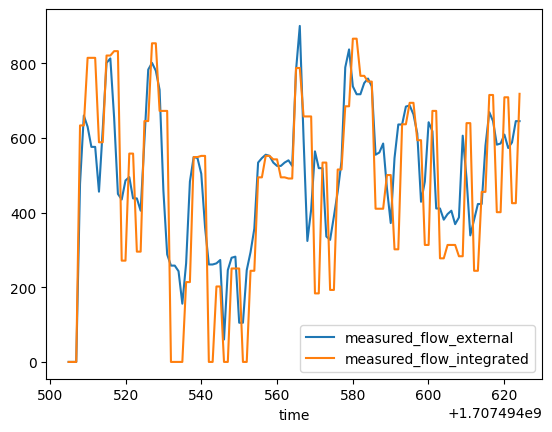

RMS error: 158.88 L/hour


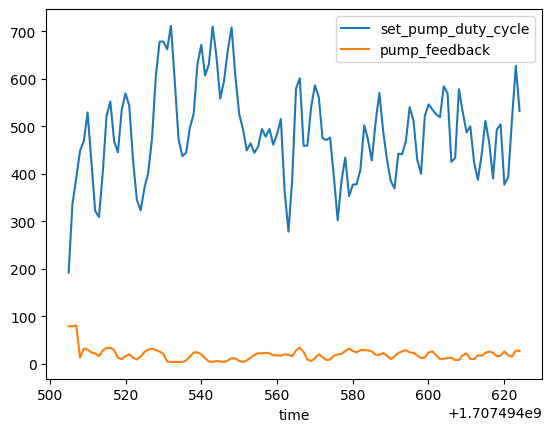

In [4]:
# Plot internal and external flow vs time
fig, ax = plt.subplots()
df_awmt.plot(x='time', y='measured_flow_external', ax=ax)
df_awmt.plot(x='time', y='measured_flow_integrated', ax=ax)
plt.show()

# RMS error
rms_error = ((df_awmt['measured_flow_integrated'] - df_awmt['measured_flow_external'])**2).mean()**0.5
print(f'RMS error: {rms_error:.2f} L/hour')

fig, ax = plt.subplots()
df_awmt.plot(x='time', y='set_pump_duty_cycle', ax=ax)
df_awmt.plot(x='time', y='pump_feedback', ax=ax)
plt.show()

### Estimate a static model for the pump (AWMT)

Pump feedback = -0.08 * set pump duty cycle + 55.04
Standard deviation of the residuals: 1.91


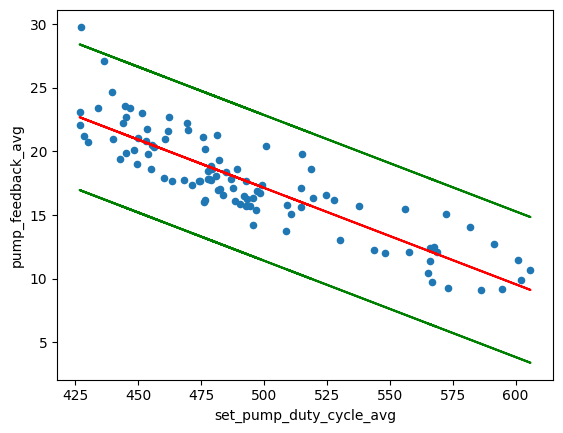

In [6]:
window_size = 20  # 10-second window size

# Calculate the moving averages
df_awmt['set_pump_duty_cycle_avg'] = df_awmt['set_pump_duty_cycle'].rolling(window_size).mean()
df_awmt['pump_feedback_avg'] = df_awmt['pump_feedback'].rolling(window_size).mean()

# Drop missing values
df_awmt_trimmed = df_awmt.dropna()

# Estimate a liner model of the pump feedback with the set pump duty cycle as input
X = df_awmt_trimmed['set_pump_duty_cycle_avg'].values.reshape(-1, 1)
y = df_awmt_trimmed['pump_feedback_avg'].values
model = LinearRegression().fit(X, y)
a = model.coef_[0]
b = model.intercept_
print(f'Pump feedback = {a:.2f} * set pump duty cycle + {b:.2f}')
# Print standard deviation of the residuals
y_pred = model.predict(X)
residuals = y - y_pred
std_residuals = np.std(residuals)
print(f'Standard deviation of the residuals: {std_residuals:.2f}')

# Plot the moving averages
fig, ax = plt.subplots()
df_awmt_trimmed.plot.scatter(x='set_pump_duty_cycle_avg', y='pump_feedback_avg', ax=ax)
ax.plot(df_awmt_trimmed['set_pump_duty_cycle_avg'], y_pred, color='red')
ax.plot(df_awmt_trimmed['set_pump_duty_cycle_avg'], y_pred + 3*std_residuals, color='green')
ax.plot(df_awmt_trimmed['set_pump_duty_cycle_avg'], y_pred - 3*std_residuals, color='green')
plt.show()


### Estimate an ARX model of the pump (AWMT)

Estimated coefficients: {'a': array([[ 0.46612803],
       [-0.08724859]]), 'b': array([[[ 0.02933746],
        [-0.0716974 ]]]), 'c': array([31.79334621])}
RMS error: 10.68
y_p(k+1) = 0.0293 * u(k) + -0.0717 * u(k-1) + 0.4661 * y_m(k) + -0.0872 * y_m(k-1) + 31.7933


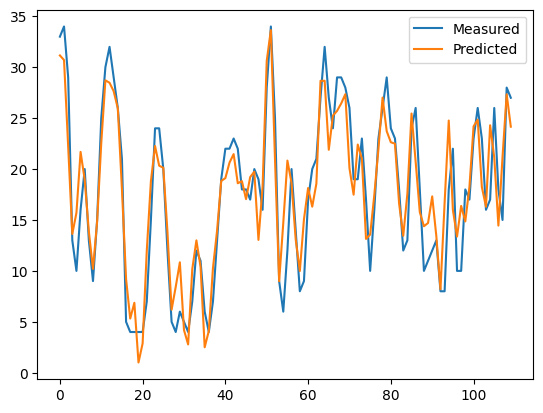

In [27]:
# Estimate a 2nd order ARX model of the pump feedback
na = 2 # output coefficients
nb = 2 # input coefficients
t = df_awmt['idx'].values
u = df_awmt['set_pump_duty_cycle'].values
y = df_awmt['pump_feedback'].values

yp, p, K = m.sysid(t, u, y, na, nb, pred='meas', shift='calc')
print(f'Estimated coefficients: {p}')
# Print rms error
rms_error = ((y[10:] - yp[10:])**2).mean()**0.5
print(f'RMS error: {rms_error:.2f}')

# Print the model in symbolic form
print(f"y_p(k+1) = {p['b'].flatten()[0]:.4f} * u(k) + {p['b'].flatten()[1]:.4f} * u(k-1) + {p['a'].flatten()[0]:.4f} * y_m(k) + {p['a'].flatten()[1]:.4f} * y_m(k-1) + {p['c'].flatten()[0]:.4f}")

# Plot the measured and predicted pump feedback
fig, ax = plt.subplots()
ax.plot(y[10:], label='Measured')
ax.plot(yp[10:], label='Predicted')
ax.legend()
plt.show()


### Estimate an OE model of the pump (AWMT)

Estimated coefficients: {'a': array([[ 0.81698531],
       [-0.349583  ]]), 'b': array([[[ 0.02413136],
        [-0.06288262]]]), 'c': array([28.47318044])}
RMS error: 11.28
y_p(k+1) = 0.0241 * u(k) + -0.0629 * u(k-1) + 0.8170 * y_p(k) + -0.3496 * y_p(k-1) + 28.4732


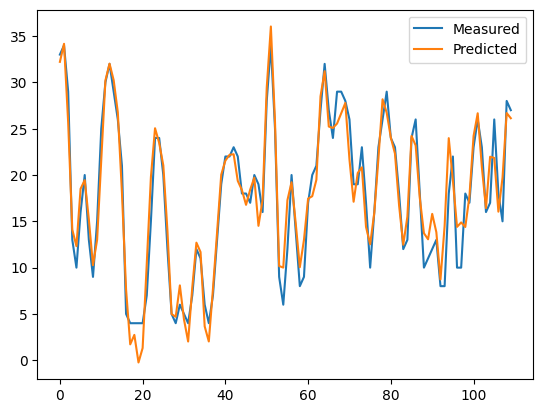

In [28]:
# Estimate a 2nd order OE model of the pump feedback
m = GEKKO(remote
            =False)
na = 2 # output coefficients
nb = 2 # input coefficients
t = df_awmt['idx'].values
u = df_awmt['set_pump_duty_cycle'].values
y = df_awmt['pump_feedback'].values

yp, p, K = m.sysid(t, u, y, na, nb, pred='model', shift='calc')
print(f'Estimated coefficients: {p}')
# Print rms error
rms_error = ((y[10:] - yp[10:])**2).mean()**0.5
print(f'RMS error: {rms_error:.2f}')

# Print the model in symbolic form
print(f"y_p(k+1) = {p['b'].flatten()[0]:.4f} * u(k) + {p['b'].flatten()[1]:.4f} * u(k-1) + {p['a'].flatten()[0]:.4f} * y_p(k) + {p['a'].flatten()[1]:.4f} * y_p(k-1) + {p['c'].flatten()[0]:.4f}")

# Plot the measured and predicted pump feedback
fig, ax = plt.subplots()
ax.plot(y[10:], label='Measured')
ax.plot(yp[10:], label='Predicted')
ax.legend()
plt.show()


## Estimate models for Wilo pump

### Load and explore data (Wilo)

In [8]:
# Load AWMT data from data directory
data_dir = os.path.join(os.getcwd(), 'data')
wilo_file = os.path.join(data_dir, 'Wilo_flow_experiment_1709121894.csv')
df_wilo = pd.read_csv(wilo_file)

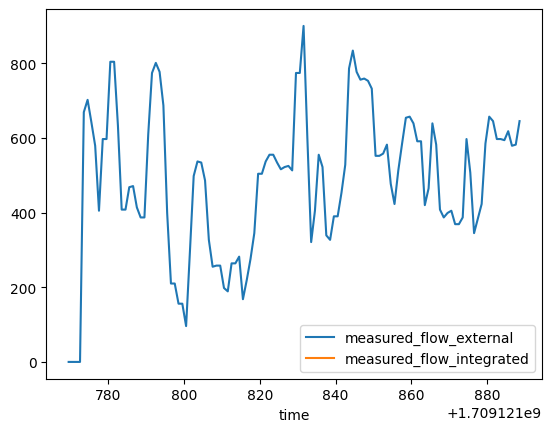

RMS error: nan L/hour


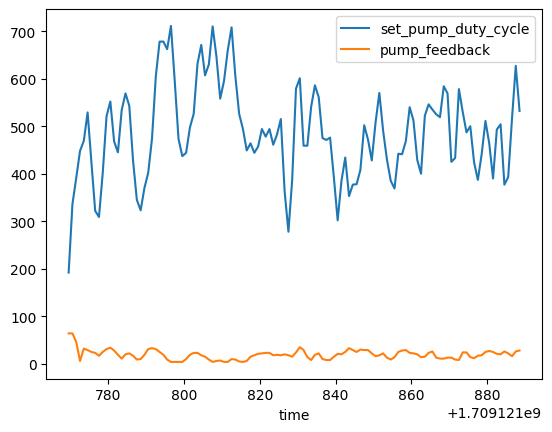

In [9]:
# Plot internal and external flow vs time
fig, ax = plt.subplots()
df_wilo.plot(x='time', y='measured_flow_external', ax=ax)
df_wilo.plot(x='time', y='measured_flow_integrated', ax=ax)
plt.show()

# RMS error
rms_error = ((df_wilo['measured_flow_integrated'] - df_wilo['measured_flow_external'])**2).mean()**0.5
print(f'RMS error: {rms_error:.2f} L/hour')

fig, ax = plt.subplots()
df_wilo.plot(x='time', y='set_pump_duty_cycle', ax=ax)
df_wilo.plot(x='time', y='pump_feedback', ax=ax)
plt.show()

### Estimate a static model for the pump (Wilo)

In [ ]:
window_size = 20  # 10-second window size

# Calculate the moving averages
df_wilo['set_pump_duty_cycle_avg'] = df_wilo['set_pump_duty_cycle'].rolling(window_size).mean()
df_wilo['pump_feedback_avg'] = df_wilo['pump_feedback'].rolling(window_size).mean()

# Drop missing values
df_wilo_trimmed = df_wilo.dropna()

# Estimate a liner model of the pump feedback with the set pump duty cycle as input
X = df_wilo_trimmed['set_pump_duty_cycle_avg'].values.reshape(-1, 1)
y = df_wilo_trimmed['pump_feedback_avg'].values
model = LinearRegression().fit(X, y)
a = model.coef_[0]
b = model.intercept_
print(f'Pump feedback = {a:.2f} * set pump duty cycle + {b:.2f}')
# Print standard deviation of the residuals
y_pred = model.predict(X)
residuals = y - y_pred
std_residuals = np.std(residuals)
print(f'Standard deviation of the residuals: {std_residuals:.2f}')

# Plot the moving averages
fig, ax = plt.subplots()
df_wilo_trimmed.plot.scatter(x='set_pump_duty_cycle_avg', y='pump_feedback_avg', ax=ax)
ax.plot(df_wilo_trimmed['set_pump_duty_cycle_avg'], y_pred, color='red')
ax.plot(df_wilo_trimmed['set_pump_duty_cycle_avg'], y_pred + 3*std_residuals, color='green')
ax.plot(df_wilo_trimmed['set_pump_duty_cycle_avg'], y_pred - 3*std_residuals, color='green')
plt.show()


### Estimate an ARX model of the pump (Wilo)

Estimated coefficients: {'a': array([[ 0.62450951],
       [-0.26666344]]), 'b': array([[[ 0.02650769],
        [-0.06131577]]]), 'c': array([28.65557087])}
RMS error: 10.24
y_p(k+1) = 0.0265 * u(k) + -0.0613 * u(k-1) + 0.6245 * y_m(k) + -0.2667 * y_m(k-1) + 28.6556


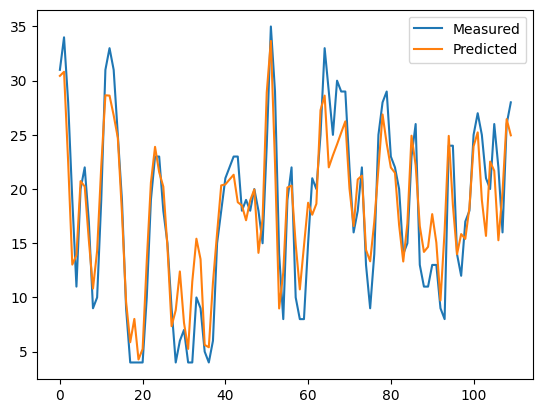

In [29]:
# Estimate a 2nd order ARX model of the pump feedback
m = GEKKO(remote
            =False)
na = 2 # output coefficients
nb = 2 # input coefficients
t = df_wilo['idx'].values
u = df_wilo['set_pump_duty_cycle'].values
y = df_wilo['pump_feedback'].values

yp, p, K = m.sysid(t, u, y, na, nb, pred='meas', shift='calc')
print(f'Estimated coefficients: {p}')
# Print rms error
rms_error = ((y[10:] - yp[10:])**2).mean()**0.5
print(f'RMS error: {rms_error:.2f}')

# Print the model in symbolic form
print(f"y_p(k+1) = {p['b'].flatten()[0]:.4f} * u(k) + {p['b'].flatten()[1]:.4f} * u(k-1) + {p['a'].flatten()[0]:.4f} * y_m(k) + {p['a'].flatten()[1]:.4f} * y_m(k-1) + {p['c'].flatten()[0]:.4f}")

# Plot the measured and predicted pump feedback
fig, ax = plt.subplots()
ax.plot(y[10:], label='Measured')
ax.plot(yp[10:], label='Predicted')
ax.legend()
plt.show()


### Estimate an OE model of the pump (Wilo)

Estimated coefficients: {'a': array([[ 0.79638413],
       [-0.37832424]]), 'b': array([[[ 0.02600482],
        [-0.06122135]]]), 'c': array([27.76945965])}
RMS error: 10.77
y_p(k+1) = 0.0260 * u(k) + -0.0612 * u(k-1) + 0.7964 * y_p(k) + -0.3783 * y_p(k-1) + 27.7695


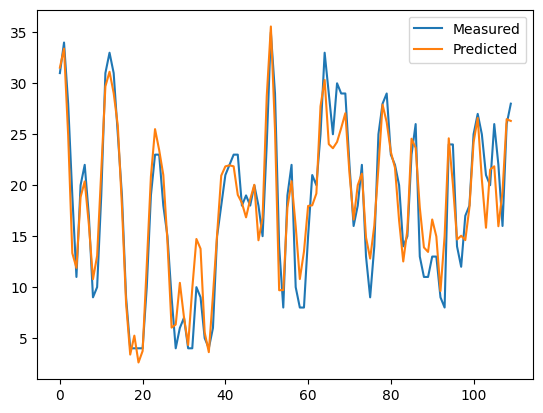

In [30]:
# Estimate a 2nd order OE model of the pump feedback
m = GEKKO(remote
            =False)
na = 2 # output coefficients
nb = 2 # input coefficients
t = df_wilo['idx'].values
u = df_wilo['set_pump_duty_cycle'].values
y = df_wilo['pump_feedback'].values

yp, p, K = m.sysid(t, u, y, na, nb, pred='model', shift='calc')
print(f'Estimated coefficients: {p}')
# Print rms error
rms_error = ((y[10:] - yp[10:])**2).mean()**0.5
print(f'RMS error: {rms_error:.2f}')

# Print the model in symbolic form
print(f"y_p(k+1) = {p['b'].flatten()[0]:.4f} * u(k) + {p['b'].flatten()[1]:.4f} * u(k-1) + {p['a'].flatten()[0]:.4f} * y_p(k) + {p['a'].flatten()[1]:.4f} * y_p(k-1) + {p['c'].flatten()[0]:.4f}")

# Plot the measured and predicted pump feedback
fig, ax = plt.subplots()
ax.plot(y[10:], label='Measured')
ax.plot(yp[10:], label='Predicted')
ax.legend()
plt.show()
